In [39]:
import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers==2.4.1
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

%matplotlib inline

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences
import pandas
import numpy as np
import seaborn as sns

In [3]:
bio = pandas.read_csv("../bio_catalog.csv")

In [4]:
bio

,Unnamed: 0,ARTIST,BORN-DIED,URL,BioText
0,0,"AACHEN, Hans von","(b. 1552, Köln, d. 1615, Praha)",https://www.wga.hu/bio/a/aachen/biograph.html,German painter. His renowned cosmopolitan Mann...
1,1,"AAGAARD, Carl Frederik","(b. 1833, Odense, d. 1895, København)",https://www.wga.hu/bio/a/aagaard/biograph.html,\nDanish painter. He left his small town for D...
2,2,"ABADIA, Juan de la",(active 1470-1490 in Huesca),https://www.wga.hu/bio/a/abadia/biograph.html,"\nSpanish painter, formerly known as the Maste..."
3,3,"ABAQUESNE, Masséot","(b. ca 1500, Cherbourg, d. 1564, Sotteville-lè...",https://www.wga.hu/bio/a/abaquesn/biograph.html,"\nFrench ceramist, who was the first grand-mas..."
4,4,"ABBATE, Niccolo dell'","(b. 1509, Modena, d. 1571, Fontainebleau)",https://www.wga.hu/bio/a/abbate/biograph.html,"\nPainter of the Bolognese school who, along w..."
...,...,...,...,...,...
5450,5451,"ZURBARÁN, Juan de","(b. 1620, Llerena, d. 1649, Sevilla)",https://www.wga.hu/bio/z/zurbarax/biograph.html,"\nPainter, son of Francisco de Zurbarán. He wa..."
5451,5452,"ZÜRN, Jörg","(b. ca. 1583, Überlingen, d. ca. 1638, Überlin...",https://www.wga.hu/bio/z/zurn/jorg/biograph.html,"\nGerman sculptor, part of a family of sculpto..."
5452,5453,"ZÜRN, Martin","(b. ca. 1585, Waldsee, d. ca. 1655, Waldsee)",https://www.wga.hu/bio/z/zurn/martin/biograph....,"\nGerman sculptor, part of a family of sculpto..."
5453,5454,"ZÜRN, Michael","(b. ca. 1626, Wasserburg am Inn, d. ca. 1691, ...",https://www.wga.hu/bio/z/zurn/michael/biograph...,"\nGerman sculptor, part of a family of sculpto..."


In [5]:
bio["Born"] = bio['BORN-DIED'].str.extract(r'([1-2][0-9]{3})')

In [9]:
bio = bio.fillna("")

In [28]:
import re
for ind, row in bio.iterrows():
    if (row["Born"] == ""):
        bio.iloc[ind,5] = str(int(re.search(r'([1][0-9])', row['BORN-DIED'])[0])*100)

In [31]:
bio["Born"] = bio["Born"].astype('int32')

<AxesSubplot:xlabel='Born', ylabel='Count'>

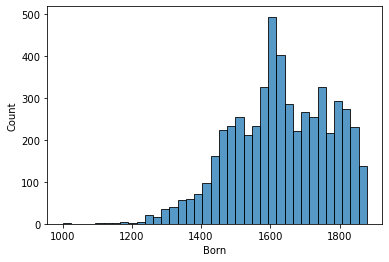

In [32]:
sns.histplot(bio["Born"])

In [37]:
# Discretization of price variable and one hot encode
from sklearn.preprocessing import KBinsDiscretizer

nbins = 4

discret = KBinsDiscretizer(n_bins=nbins, encode='ordinal', strategy='kmeans')
discret.fit(bio["Born"].to_numpy().reshape(-1, 1))
print(discret.bin_edges_)
# PriceBin 0: 10-14th century 1: 15-16th, 2: 16th-18th, 3. late 18th
bio["BornEra"] = pandas.Series(discret.transform(bio["Born"].to_numpy().reshape(-1, 1)).reshape(-1).astype("int32"))

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
bio["BornEra_OneHot"] = list(enc.fit_transform(bio["BornEra"].to_numpy().reshape(-1, 1)).toarray())



[array([1000.        , 1415.59132796, 1560.34484643, 1707.66272377,
       1879.        ])]


In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizeText = tokenizer(list(bio["BioText"].values), padding=True, truncation=True)

bio["input_ids"] = tokenizeText["input_ids"]
bio["attention_mask"] = tokenizeText["attention_mask"]

In [42]:
# # Entry point
# bio = pd.read_pickle("./artistBio.pkl")

# Stratified train-test split
from sklearn.model_selection import StratifiedShuffleSplit
strata = bio["BornEra"]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

for trainInd, testInd in sss.split(bio, strata):
    train = bio.iloc[trainInd,:]
    test = bio.iloc[testInd,:]
    
VAL_SIZE = 100 # data size too small

# Use ordinal data label
trainX = np.asarray(train["input_ids"][VAL_SIZE:].tolist())
trainY = np.asarray(train["BornEra"][VAL_SIZE:].tolist()).reshape(-1)
trainMask = np.asarray(train["attention_mask"][VAL_SIZE:].tolist())

valX = np.asarray(train["input_ids"][:VAL_SIZE].tolist())
valY = np.asarray(train["BornEra"][:VAL_SIZE].tolist()).reshape(-1)
valMask = np.asarray(train["attention_mask"][:VAL_SIZE].tolist())

testX = np.asarray(test["input_ids"].tolist())
testY = np.asarray(test["BornEra"].tolist()).reshape(-1)
testMask = np.asarray(test["attention_mask"].tolist())

# # Use one hot encode label
# trainX = np.asarray(train["input_ids"][VAL_SIZE:].tolist())
# trainY = np.asarray(train["PriceBin_OneHot"][VAL_SIZE:].tolist())
# trainMask = np.asarray(train["attention_mask"][VAL_SIZE:].tolist())

# valX = np.asarray(train["input_ids"][:VAL_SIZE].tolist())
# valY = np.asarray(train["PriceBin_OneHot"][:VAL_SIZE].tolist())
# valMask = np.asarray(train["attention_mask"][:VAL_SIZE].tolist())

# testX = np.asarray(test["input_ids"].tolist())
# testY = np.asarray(test["PriceBin_OneHot"].tolist())
# testMask = np.asarray(test["attention_mask"].tolist())

bio.to_pickle("./artistBio.pkl")

In [66]:
# Data process for pytorch and BERT
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

train_X = torch.tensor(trainX, dtype=torch.long)
val_X = torch.tensor(valX, dtype=torch.long)
test_X = torch.tensor(testX, dtype=torch.long)

train_label = torch.tensor(trainY, dtype=torch.long)
val_label = torch.tensor(valY, dtype=torch.long)
test_label = torch.tensor(testY, dtype=torch.long)

train_mask = torch.tensor(trainMask, dtype=torch.long)
val_mask = torch.tensor(valMask, dtype=torch.long)
test_mask = torch.tensor(testMask, dtype=torch.long)

# Combine the training inputs into a TensorDataset.
train_set = TensorDataset(train_X, train_mask, train_label)
val_set = TensorDataset(val_X, val_mask, val_label)
test_set = TensorDataset(test_X, test_mask, test_label)

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 4

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_set, # The validation samples.
            sampler = SequentialSampler(test_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [67]:
# Readying helper func and param
from transformers import BertForSequenceClassification, AdamW, BertConfig
import random
from torch.nn import functional as F
import time
import datetime
from transformers import get_linear_schedule_with_warmup

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# # Tell pytorch to run this model on the GPU.
optimizer = AdamW(model.parameters(),
                  lr = 2e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [68]:
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

device = torch.device("cuda")

In [69]:
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
#         b_input_ids = batch[0]
#         b_input_mask = batch[1]
#         b_labels = batch[2]

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()   
        
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        loss = F.cross_entropy(logits, b_labels)
        
        
#         loss, logits = model(b_input_ids, 
#                              token_type_ids=None, 
#                              attention_mask=b_input_mask, 
#                              labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            loss = F.cross_entropy(logits, b_labels)
            
#             (loss, logits) = model(b_input_ids, 
#                                    token_type_ids=None, 
#                                    attention_mask=b_input_mask,
#                                    labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch   100  of  1,203.    Elapsed: 0:00:25.
  Batch   200  of  1,203.    Elapsed: 0:00:50.
  Batch   300  of  1,203.    Elapsed: 0:01:15.
  Batch   400  of  1,203.    Elapsed: 0:01:41.
  Batch   500  of  1,203.    Elapsed: 0:02:06.
  Batch   600  of  1,203.    Elapsed: 0:02:32.
  Batch   700  of  1,203.    Elapsed: 0:02:58.
  Batch   800  of  1,203.    Elapsed: 0:03:24.
  Batch   900  of  1,203.    Elapsed: 0:03:50.
  Batch 1,000  of  1,203.    Elapsed: 0:04:16.
  Batch 1,100  of  1,203.    Elapsed: 0:04:41.
  Batch 1,200  of  1,203.    Elapsed: 0:05:07.

  Average training loss: 0.83
  Training epcoh took: 0:05:08

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.47
  Validation took: 0:00:02

======== Epoch 2 / 2 ========
Training...
  Batch   100  of  1,203.    Elapsed: 0:00:26.
  Batch   200  of  1,203.    Elapsed: 0:00:52.
  Batch   300  of  1,203.    Elapsed: 0:01:18.
  Batch   400  of  1,203.    Elapsed: 0:01:44.
  Batch  

In [70]:
# Display floats with two decimal places.
pandas.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pandas.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.83,0.47,0.80,0:05:08,0:00:02
2,0.39,0.42,0.81,0:05:12,0:00:02


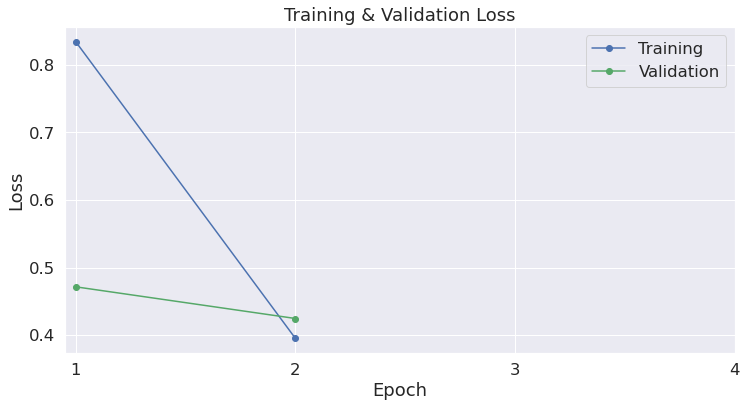

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [73]:
model.cuda()
device = torch.device("cuda")
total_eval_loss = 0
total_eval_accuracy = 0
# Tell pytorch not to bother with constructing the compute graph during
# the forward pass, since this is only needed for backprop (training).
with torch.no_grad():        

    for batch in test_dataloader:
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            loss = F.cross_entropy(logits, b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

# Report the final accuracy for this validation run.
avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
print("Test Accuracy: {0:.2f}".format(avg_val_accuracy))
avg_val_loss = total_eval_loss / len(test_dataloader)
print("Test Loss: {0:.2f}".format(avg_val_loss))

Test Accuracy: 0.85
Test Loss: 0.43


In [74]:
model.to('cpu')
model.save_pretrained('./artBioBERT/')